# Delay 100K, 1 Hour, 1-8 nodes

In [6]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

In [7]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}


def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... done: " + os.path.basename(results)
    return stats

In [15]:
dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "1 Node", d+"nano/sepminima/scale-workers-1-71033"))
stats.append(parse(dfs, "2 Node", d+"nano/sepminima/scale-workers-2-71035"))
stats.append(parse(dfs, "4 Node", d+"nano/sepminima/scale-workers-4-71036"))
stats.append(parse(dfs, "8 Node", d+"nano/sepminima/scale-workers-8-71037"))

... done: scale-workers-1-71033
... done: scale-workers-2-71035
... done: scale-workers-4-71036
... done: scale-workers-8-71037


## Trajactory

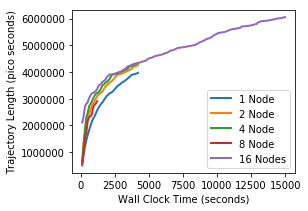

In [4]:
d = "../experiments/baseline-trinitite/"
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_times(ax, "1 Node", d+"nano/sepminima/scale-workers-1-71033")
plot_times(ax, "2 Node", d+"nano/sepminima/scale-workers-2-71035")
plot_times(ax, "4 Node", d+"nano/sepminima/scale-workers-4-71036")
plot_times(ax, "8 Node", d+"nano/sepminima/scale-workers-8-71037")
plot_times(ax, "16 Nodes", d+"nano/scale-workers/scale-workers-16-71161")


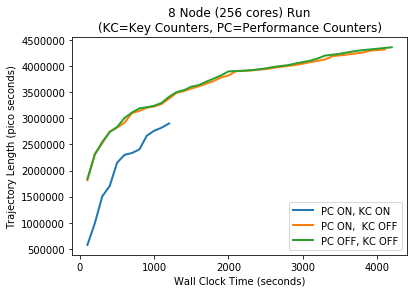

In [87]:
fig, ax = plt.subplots(1, 1)
ax.set_title("8 Node (256 cores) Run\n(KC=Key Counters, PC=Performance Counters)")
plot_times(ax, "PC ON, KC ON",   d+"nano/sepminima/scale-workers-8-71037")
plot_times(ax, "PC ON,  KC OFF", d+"nano/sepminima/scale-workers-8-71074")
plot_times(ax, "PC OFF, KC OFF", d+"nano/sepminima/scale-workers-8-71057")

## Keyspace Size, Puts/Gets

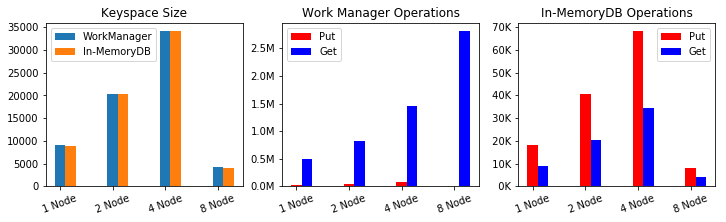

In [17]:
def plot_keyspace(key_names):
    def get_keys(op, rank):
        ret = []
        for name in key_names:
            ret.append((name, op, rank))
        return ret
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].set_title("Keyspace Size")
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "4")],
              label="WorkManager", width=0.2)
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "3"))) + 0.2,
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "3")],
              label="In-MemoryDB", width=0.2)
    
    ax[1].set_title("Work Manager Operations")
    ax[1].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryPut", "4")],
              label="Put", width=0.2, color='red')
    ax[1].bar(np.arange(len(get_keys("DBMemoryGet", "4"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryGet", "4")],
              label="Get", width=0.2, color='blue')
    ax[1].set_yticklabels(['{:3.1f}M'.format(x/1000000) for x in ax[1].get_yticks()])

    ax[2].set_title("In-MemoryDB Operations")
    ax[2].bar(np.arange(len(get_keys("DBMemoryPut", "3"))),
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryPut", "3")],
              label="Put", width=0.2, color='red')
    ax[2].bar(np.arange(len(get_keys("DBMemoryGet", "3"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryGet", "3")],
              label="Get", width=0.2, color='blue')
    ax[2].set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax[2].get_yticks()])

    for a in range(0, len(ax)):
        ax[a].set_xticklabels([k[0] for k in get_keys("DBMemoryPut", "4")], rotation=20)
        ax[a].set_xticks(range(0, len(get_keys("DBMemoryPut", "4"))))
        ax[a].legend()

plot_keyspace(["1 Node", "2 Node", "4 Node", "8 Node"])

## Key Popularity

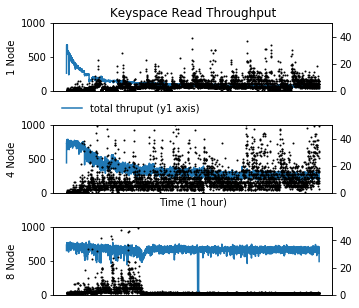

In [27]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="total thruput (y1 axis)")
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=1, label="unique keys (y2 axis)")
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 50)
    return ax2

fig, ax = plt.subplots(3, 1, figsize=(5, 5))
fig.subplots_adjust(hspace=.5)
plot_uniquekeys_per_ts(ax[0], dfs, ("1 Node", "DBMemoryGet", "4"))
plot_uniquekeys_per_ts(ax[1], dfs, ("4 Node", "DBMemoryGet", "4"))
plot_uniquekeys_per_ts(ax[2], dfs, ("8 Node", "DBMemoryGet", "4"))
ax[0].set_xlabel("")
for i in range(0, len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_ylim(0, 1000)
ax[1].set_xlabel("Time (1 hour)")
ax[1].legend(bbox_to_anchor=(0, 1.45), loc='upper left', frameon=False)
ax2.legend(bbox_to_anchor=(0.5, 1.45), loc='upper left', frameon=False)
ax[0].set_title("Keyspace Read Throughput")
ax[0].set_ylabel("1 Node")
ax[1].set_ylabel("4 Node")
ax[2].set_ylabel("8 Node")

In [66]:
def plot_keyspace(ax, op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    label = os.path.basename(results).split('-')[2] + " nodes"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend()
    
def plot_normkeyspace(ax, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])

    ax.set_title("Size of 1 KV-pair")
    df_data = df[df['op'] == 'DBMemorySize']
    df_keys = df[df['op'] == 'DBMemoryMapSize']
    joined = pd.merge(df_data, df_keys, on='ts')
    joined['size'] = joined['count_x']/joined['count_y']
    shift = np.min(joined['ts']) * np.ones(len(joined['ts']))
    ax.plot(joined['ts'] - shift, joined['size'])


## Key Size: 100MB / 35000

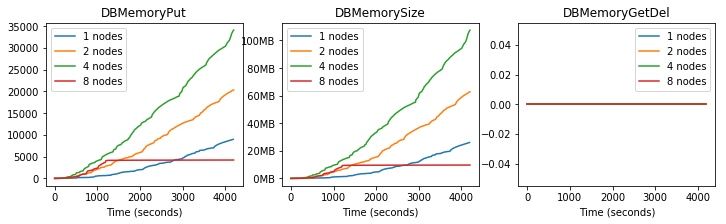

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
d = "../experiments/baseline-trinitite/"
for run in ["nano/sepminima/scale-workers-1-71033",
            "nano/sepminima/scale-workers-2-71035",
            "nano/sepminima/scale-workers-4-71036",
            "nano/sepminima/scale-workers-8-71037"]:
    plot_keyspace(ax[0], "DBMemoryPut", d+run)
    plot_keyspace(ax[1], "DBMemorySize", d+run)
    plot_keyspace(ax[2], "DBMemoryGetDel", d+run)

    #plot_normkeyspace(ax[2], d+run)

ax[1].set_yticklabels(['{:3.0f}MB'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])


for a in range(0, len(ax)):
    ax[a].legend()
    #ax[a].set_xticklabels([])

In [49]:
(100*1024*1024) / 3500

29959

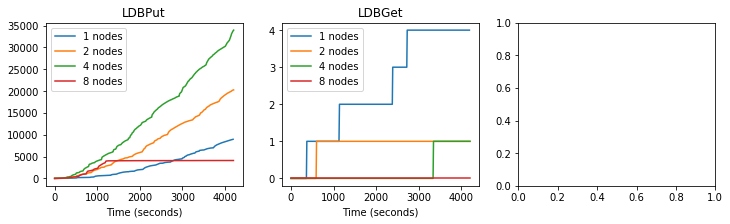

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
d = "../experiments/baseline-trinitite/"
for run in ["nano/sepminima/scale-workers-1-71033",
            "nano/sepminima/scale-workers-2-71035",
            "nano/sepminima/scale-workers-4-71036",
            "nano/sepminima/scale-workers-8-71037"]:
    plot_keyspace(ax[0], "LDBPut", d+run, rank="2")
    plot_keyspace(ax[1], "LDBGet", d+run, rank="2")